# Alpha Epsilon Gomoku: Quick Overview

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
print(tf.config.list_logical_devices('GPU'))
tf.__version__

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]Metal device set to: Apple M1 Max



2022-10-22 11:50:35.065958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-22 11:50:35.066087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'2.10.0'

## Data storage locations

In [3]:
from setup_local import DATA_PATH
from pathlib import Path
print(DATA_PATH)
list(Path.glob(DATA_PATH / 'models', "*"))

/Users/wgiersche/workspace/Project-Ellie/DeepGomoku/DATA


[PosixPath('/Users/wgiersche/workspace/Project-Ellie/DeepGomoku/DATA/models/2_c1.model'),
 PosixPath('/Users/wgiersche/workspace/Project-Ellie/DeepGomoku/DATA/models/4_c2s.model'),
 PosixPath('/Users/wgiersche/workspace/Project-Ellie/DeepGomoku/DATA/models/3_c2.model'),
 PosixPath('/Users/wgiersche/workspace/Project-Ellie/DeepGomoku/DATA/models/1_c3.model')]

# The game

In [4]:
BOARD_SIZE=19

In [5]:
from aegomoku.gomoku_game import GomokuGame, ConstantBoardInitializer

# Standard Gomoku
initializer = ConstantBoardInitializer(
    stones='J10K9J9J8L10K10K11I9J12I13J11J13I11H11L11M11L12L9M13N14L13L14N13O13M9N8')
game = GomokuGame(board_size=BOARD_SIZE, initializer=initializer)

### Preparing the policy-advised graph search algorithm

---

# Make it all visible

### The canonical representation: 3 channels and boundary stones

In [11]:
from aegomoku.tools import print_channels

board = game.get_initial_board()
print(board)
print()
print_channels(board.canonical_representation())

... M13 N14 L13 L14 N13 O13 M9 N8 (Black next)

shape: (21, 21, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 2 2 0 1 1 1 2 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 2 1 1 1 1 2 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 1 2 1 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 2 1 2 2 1 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

#### A bit more comfortable: Plot the board

In [13]:
board.plot()

                                                                 
19    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
18    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
17    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
16    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  O  .  O  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  O  O  .  X  X  X  O  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  X  .  X  .  .  .  .  .  .  .    
11    .  .  .  .  .  .  .  O  X  X  X  X  O  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  X  O  X  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  .  .  O  X  O  O  X  .  .  .  .  .  .    
 8    .  .  .  .  .  .  .  .  .  O  .  .  . [O] .  .  .  .  .    
 7    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 5    .  .

### Advice is a specialized interface to the policy model

In [14]:
from aegomoku.policies.topological_value import TopologicalValuePolicy

adviser = TopologicalValuePolicy(BOARD_SIZE, advice_cutoff=.02)

In [15]:
import numpy as np

# Get the canonical representation from the board
state = board.canonical_representation()

# See what the policy thinks
advice = adviser.advise(state)

# Integers are easier to visualize
advice = (advice * 500).astype(np.uint)

# make it 2-dimensional
reshaped = advice.reshape(BOARD_SIZE, BOARD_SIZE)
print(reshaped)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  4  8  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  3 17  0 83  0 36  0  0  0  0]
 [ 0  0  0  0  0  0 34  4  0  0 22  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0 12 79  0 13  0  0 23  1  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4 80  6  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  7  5  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0

Note that this advice comes from the very naive topological value policy.

#### Moves to consider - a service to the graph search

In [17]:
print(adviser.get_advisable_actions(state))

[87, 88, 89, 104, 105, 107, 109, 120, 121, 124, 138, 140, 141, 143, 146, 147, 148, 177, 178, 179, 196, 197, 214, 219, 220, 221, 238, 278, 150, 216, 215, 129, 243, 102, 185, 154, 77]


#### The direct interface to the Keras model

In [18]:
p, v = adviser.evaluate(state)
p.shape, v

((361,), -0.0990959)

#### The best move (?)

In [21]:
highest_prob = np.max(advice)
best_move = np.where(advice == highest_prob)
best_move = int(best_move[0])
Move = board.Stone

print(f'Action: {best_move} - Move: {Move(best_move)}')

Action: 107 - Move: M14


### Matplotlib-based board

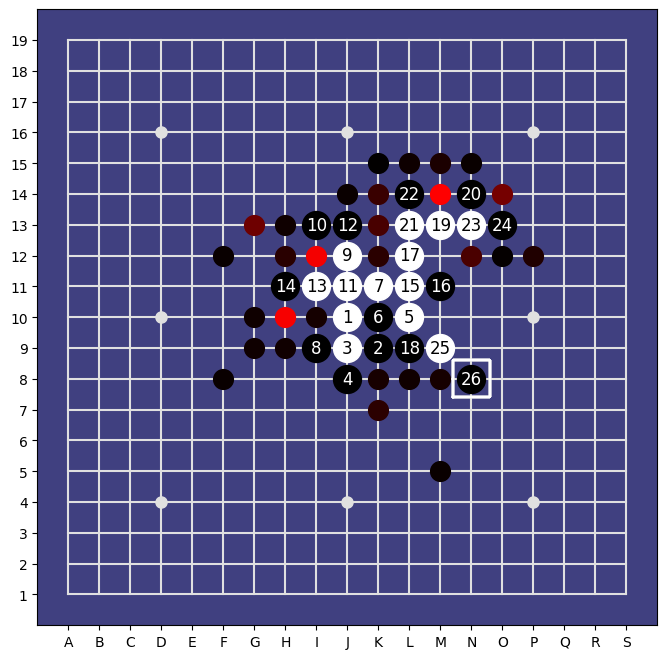

In [22]:
from aegomoku.mpl_board import MplBoard

mpl_board = MplBoard(BOARD_SIZE, adviser, stones=board.stones, disp_width=8, policy_cutoff=0.1)
mpl_board.display()

## Graph search augments the policy
Please note that you need to run `get_action_prob` three times to actually arrive at the expected learning. So the number of simulations will have to be around 1800, which is what David Silver found on Go, too.

In [23]:
from aegomoku.mcts import MCTS
from aegomoku.interfaces import MctsParams

pags_params = MctsParams(cpuct=1.0, temperature=0.5, num_simulations=600, gamma=1.0)
pags = MCTS(game, adviser, params=pags_params)

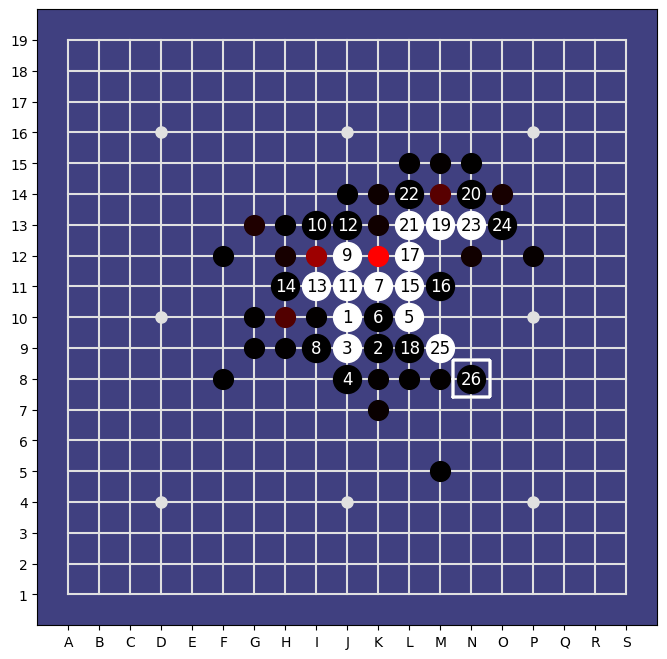

In [26]:
mcts_probs = pags.get_action_prob(board, temperature=.8)
MplBoard(BOARD_SIZE, mcts_probs, stones=board.stones, disp_width=8, policy_cutoff=0.1).display()

## Compare to 4-th generation policy
The 4-th generation adviser has already aquired that knowledge.

In [27]:
from aegomoku.advice import PolicyAdviser
from aegomoku.interfaces import PolicyParams


# We store full models - not just the parameters. You can just load any model
policy_params = PolicyParams(
    DATA_PATH / 'models' / '4_c2s.model',
    advice_cutoff=.02  # ignore advice with probability less than this
)

model = tf.keras.models.load_model(policy_params.model_file_name)
model.summary()

adviser = PolicyAdviser(model, policy_params, board_size=BOARD_SIZE)

# MCTS, or rather policy-advised graph search
pags_params = MctsParams(cpuct=1.0, temperature=0.5, num_simulations=600, gamma=1.0)
pags = MCTS(game, adviser, pags_params)

Model: "gomoku_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 21, 21, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 21, 21, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 21, 21, 512)  186368      ['inputs[0][0]']                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 21, 21, 5)    1540        ['heuristic_detector[0][0]']     
                                                                                      

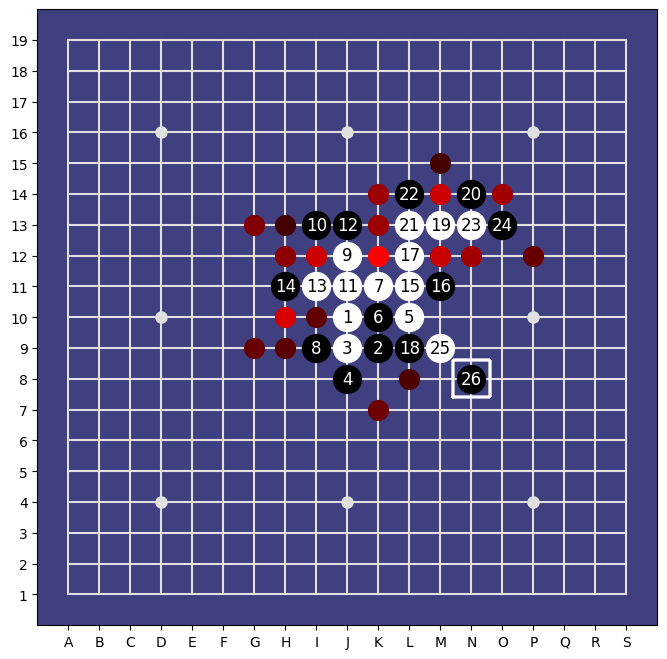

In [35]:
MplBoard(BOARD_SIZE, adviser, stones=board.stones, disp_width=8).display()